In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVR,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn import datasets, linear_model, metrics
import _pickle as pickle
import math
import numpy as np
import h5py
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.python.keras.layers as tfl
from tensorflow.python.framework import ops
#from cnn_utils import *
#from test_utils import summary, comparator
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from tensorflow.keras import regularizers


In [2]:
from diffgrad import DiffGrad

In [3]:
tf.keras.backend.set_floatx('float64')
#%matplotlib widget
import matplotlib.pyplot as plt
import tensorflow.python.keras.backend as K

In [4]:
with open("dataa", "rb") as input_file:
   df = pickle.load(input_file)

In [5]:
df['CH2']=[np.nan]*len(df)
for i in range(len(df)):
    if df['CH2_SHELA'].iloc[i]!=-99 :
        if df['CH2_SPIES'].iloc[i]!=-99 :
            df['CH2'].iloc[i]=(df['CH2_SPIES'].iloc[i]+df['CH2_SHELA'].iloc[i])/2
        else :
            df['CH2'].iloc[i]=df['CH2_SHELA'].iloc[i]
    elif df['CH2_SPIES'].iloc[i]!=-99 :
        df['CH2'].iloc[i]=df['CH2_SPIES'].iloc[i]
df['CH1']=[np.nan]*len(df)
for i in range(len(df)):
    if df['CH1_SHELA'].iloc[i]!=-99 :
        if df['CH1_SPIES'].iloc[i]!=-99 :
            df['CH1'].iloc[i]=(df['CH1_SPIES'].iloc[i]+df['CH1_SHELA'].iloc[i])/2
        else :
            df['CH1'].iloc[i]=df['CH1_SHELA'].iloc[i]
    elif df['CH1_SPIES'].iloc[i]!=-99 :
        df['CH1'].iloc[i]=df['CH1_SPIES'].iloc[i]
    else :
        df['CH1'].iloc[i]=np.nan
dff=df[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2','REDSHIFT','REDSHIFT_ERR','ZWARNING']].dropna()
dff[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2','REDSHIFT']]=dff[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2','REDSHIFT']].replace(-99,np.nan).dropna()
dff=dff.where(dff['REDSHIFT_ERR']<dff['REDSHIFT']*0.1).dropna()
X_data,y_data=dff[['K','G','CH1','W1','U','Z','J','W2','I','H','R','CH2']],dff['REDSHIFT']

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
def Model2(l2=1e-2):
    model = tf.keras.Sequential([
        tfl.Dense(25,'tanh',input_shape=(12,),kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(25,'tanh',kernel_regularizer=regularizers.l2(l2)),
        tfl.Dense(1,'linear',kernel_regularizer=regularizers.l2(l2)),
        ])
    return model

In [7]:
inscaler = MinMaxScaler((-1,1))
ouscaler = MinMaxScaler()
Xs_data  = inscaler.fit_transform(X_data)
ys_data  = ouscaler.fit_transform(np.array(y_data).reshape(-1,1))

In [8]:
def plot_his(history,n='n'):
    if n=='n':
        N=len(history)
        hisloss=np.sum([history[i].history['loss'] for i in range(N)],axis=0)/N
        hisval=np.sum([history[i].history['val_loss'] for i in range(N)],axis=0)/N
    else :
        hisloss=history[n].history['loss']
        hisval=history[n].history['val_loss']
    plt.figure()
    plt.plot(hisloss)
    plt.plot(hisval)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [ ]:
'''import zipfile as zf
files = zf.ZipFile("model_1_8_10.zip", 'r')
files.extractall()
files.close()'''

In [ ]:
infile = open('0.001_9_10.pkl','rb')
hisloss,hisval = pickle.load(infile)
infile.close()

In [ ]:
def plot_h(hisloss,hisval):
    plt.figure()
    plt.plot(hisloss)
    plt.plot(hisval)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [ ]:
N=int(len(Xs_data)/4)
history4=[]
dz_val,dz_train=[],[]
for i in range(4):
    Xs_train,y_train=list(Xs_data.copy()),list(y_data.copy())
    del Xs_train[i*N:i*N+N]
    del y_train[i*N:i*N+N]
    Xs_val,y_val=Xs_data[i*N:i*N+N],y_data[i*N:i*N+N]

    ouscaler= MinMaxScaler()
    ys_train= ouscaler.fit_transform(np.array(y_train).reshape(-1,1))
    ys_val  = ouscaler.transform(np.array(y_val).reshape(-1,1))

    Xs_train,Xs_val,ys_train,ys_val,y_val,y_train=np.array(Xs_train),np.array(Xs_val),np.array(ys_train),np.array(ys_val),np.array(y_val),np.array(y_train)

    model4 = Model2(1e-2)
    optimizer=DiffGrad()
    model4.compile(optimizer=optimizer,loss='MAE')
    h=model4.fit(Xs_train, ys_train, validation_data=(Xs_val,ys_val), epochs=3000,verbose=0)
    
    pred_train=ouscaler.inverse_transform(model4.predict(Xs_train)).reshape(len(y_train))
    pred_val=ouscaler.inverse_transform(model4.predict(Xs_val)).reshape(len(y_val))
    dz_val.append(np.array((pred_val-y_val)/(1+y_val)))
    dz_train.append(np.array((pred_train-y_train)/(1+y_train)))
    print('std train:',np.std(dz_train[-1]),'\nmean train:',np.mean(dz_train[-1]))
    print('std val:',np.std(dz_val[-1]),'\nmean val:',np.mean(dz_val[-1]))
    history4.append(h)

std train: 0.19599028350940936 
mean train: -0.003846921802654504
std val: 0.2009606594697819 
mean val: -0.0001344311273877002
std train: 0.1930951852240644 
mean train: -0.0008818653279541411
std val: 0.2077217541987903 
mean val: 0.0020416116067894273


In [13]:
print('train : \nstd :',np.mean([np.std(dz_train[i]) for i in range(4)]),'\nmean :',np.mean(np.abs([np.mean(dz_train[i]) for i in range(4)])))
print('val   : \nstd :',np.mean([np.std(dz_val[i]) for i in range(4)]),'\nmean :',np.mean(np.abs([np.mean(dz_val[i]) for i in range(4)])))

train : 
std : 0.19692240706454936 
mean : 0.004992046072076527
val   : 
std : 0.19719447841238458 
mean : 0.011957924263968599


<IPython.core.display.Javascript object>


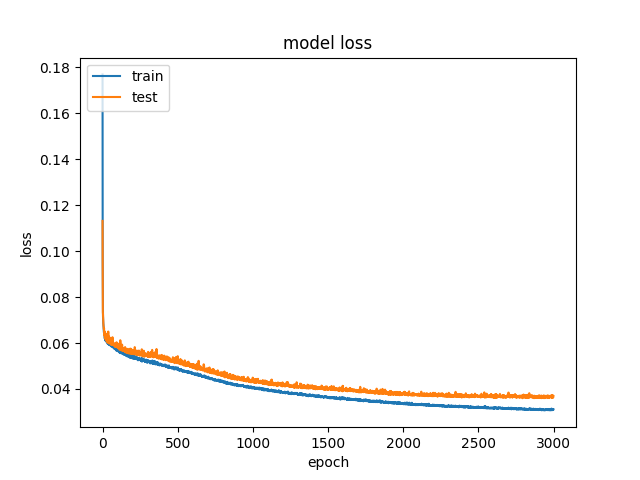

In [11]:
plot_his(history4)

In [ ]:
for i in range(4):
    plot_h(hisloss[4*i:4*i+4],hisval[4*i:4*i+4])

In [14]:
len(history4)

4

In [ ]:
!conda install -c conda-forge -y npm

In [ ]:
!conda update -y tornado